## ChatGPT 4.0 API

In [1]:
from openai import OpenAI

client = OpenAI(
    api_key = ""
)

response = client.chat.completions.create(
  model="gpt-4-turbo",
  messages=[
    {
      "role": "user",
      "content": [
        {"type": "text", "text": "What’s in this image?"},
        {
          "type": "image_url",
          "image_url": {
            "url": "https://upload.wikimedia.org/wikipedia/commons/thumb/d/dd/Gfp-wisconsin-madison-the-nature-boardwalk.jpg/2560px-Gfp-wisconsin-madison-the-nature-boardwalk.jpg",
          },
        },
      ],
    }
  ],
  max_tokens=300,
)


In [4]:
import base64
def encode_image(image_path):
  with open(image_path, "rb") as image_file:
    return base64.b64encode(image_file.read()).decode('utf-8')

In [5]:
image_path = "image1.jpg"
base64_image = encode_image(image_path)

In [8]:
response = client.chat.completions.create(
  model="gpt-4-turbo",
  messages=[
    {
      "role": "user",
      "content": [
        {"type": "text", "text": "What’s in this image, answer in two sentences?"},
        {
          "type": "image_url",
          "image_url": {
            "url":  f"data:image/jpeg;base64,{base64_image}",
          },
        },
      ],
    }
  ],
  max_tokens=300,
)

In [9]:
reply = response.choices[0].message.content
print(reply)

The image features three colorful bowls in orange, green, and blue, placed on a pink rectangular mat with a pale background. Additionally, there are four cubes in orange, blue, green, and red colors, grouped near each other on the same mat.


## LangChain ChatGPT4_vision

In [5]:
from langchain.chains import TransformChain
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI
from langchain import globals
from langchain_core.runnables import chain

In [13]:
OPENAI_API_KEY = ""
import os
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

In [40]:
from langchain_core.pydantic_v1 import BaseModel, Field

class ImageInformation(BaseModel):
    """Information about an image."""
    image_description: list[str] = Field(description="list each available objects")
    planner: list[str] = Field(description="list each of the movement step to place objects into bowls of corresponding colors ")

In [41]:
from langchain_core.output_parsers import JsonOutputParser

parser = JsonOutputParser(pydantic_object=ImageInformation)

In [35]:
from langchain.schema import HumanMessage, SystemMessage, AIMessage

In [42]:
# Set verbose
globals.set_debug(True)

@chain
def image_model(inputs: dict) -> str | list[str] | dict:
 """Invoke model with image and prompt."""
 model = ChatOpenAI(temperature=0.5, model="gpt-4-vision-preview", max_tokens=1024)
#  model([
#     SystemMessage(content="You are a robot controller to control the robot to pick and place object. \
#                   available scene objects: ['green bowl', 'red bowl'], [blue bowl], [green block], [blue block], [red block]\
#                   available movement: ['move'], ['pick'], [place]"),
# ])
 msg = model.invoke(
             [  SystemMessage(content="You are a robot controller to control the robot to pick and place object. \
                  available scene objects: ['green bowl', 'red bowl'], [blue bowl], [green block], [blue block], [red block]\
                  available movement: ['move'], ['pick'], [place]"),
              
               HumanMessage(
             content=[
             {"type": "text", "text": inputs["prompt"]},
             {"type": "text", "text": parser.get_format_instructions()},
             {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{inputs['image']}"}},
             ])]
             )
 return msg.content

In [43]:
def get_image_informations(image_path: str) -> dict:
   vision_prompt = """
   Given the image, provide the following information:
   - A count of how many people are in the image
   - A list of the main objects present in the image
   - A description of the image
   """
   vision_chain = load_image_chain | image_model | parser
   return vision_chain.invoke({'image_path': f'{image_path}', 
                               'prompt': vision_prompt})

In [ ]:
result = get_image_informations("image1.jpg")

In [48]:
print(result['planner'])
print(result['image_description'])

['move to red block', 'pick red block', 'move to red bowl', 'place red block', 'move to blue block', 'pick blue block', 'move to blue bowl', 'place blue block', 'move to green block', 'pick green block', 'move to green bowl', 'place green block']
['green bowl', 'red bowl', 'blue bowl', 'green block', 'blue block', 'red block']


In [ ]:
from transformers import pipeline

checkpoint = "google/owlv2-base-patch16-ensemble"

from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection

model = AutoModelForZeroShotObjectDetection.from_pretrained(checkpoint)
processor = AutoProcessor.from_pretrained(checkpoint)

In [ ]:
import numpy as np
from PIL import Image

FILE_PATH = "image1.jpg"
im = Image.open(FILE_PATH)

## Langchain simple test

In [20]:
import base64
def encode_image(image_path):
  with open(image_path, "rb") as image_file:
    return base64.b64encode(image_file.read()).decode('utf-8')

In [21]:
image_path = "image1.jpg"
base64_image = encode_image(image_path)

c:\Users\szheng2\OneDrive - Clemson University\Desktop\Spring2024\hw\hw3\langchain_project\.venv\Lib\site-packages\langchain_core\_api\deprecation.py:117: LangChainDeprecationWarning: The class `langchain_community.chat_models.openai.ChatOpenAI` was deprecated in langchain-community 0.0.10 and will be removed in 0.2.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import ChatOpenAI`.
  warn_deprecated(


[llm/start] [1:llm:ChatOpenAI] Entering LLM run with input:
{
  "prompts": [
    "Human: [{'type': 'text', 'text': 'What is this image showing'}, {'type': 'image_url', 'image_url': {'url': '', 'detail': 'auto'}}]"
  ]
}
[llm/end] [1:llm:ChatOpenAI] [6.47s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "This image shows a simple color-matching activity that might be used for educational or developmental purposes. There are three colored bowls – orange, green, and blue – arranged on a table with a pink border. Directly in front of each bowl, there is a cube with a matching color. The orange cube is placed in front of the orange bowl, the green cube in front of the green bowl, and the blue cube in front of the blue bowl. This setup is likely designed to teach or test color recognition and matching skills, possibly for young children or individuals learning these basic concepts.",
        "generation_info": {
          "finish_reason": "stop",
          "l
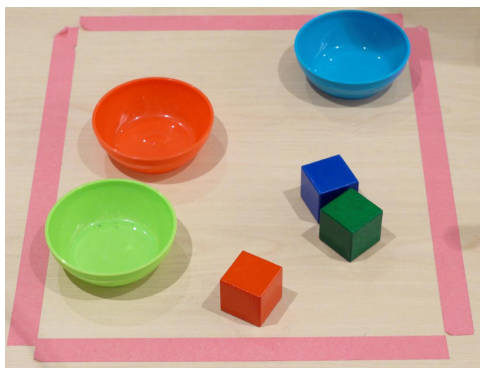

AIMessage(content='This image shows a simple color-matching activity that might be used for educational or developmental purposes. There are three colored bowls – orange, green, and blue – arranged on a table with a pink border. Directly in front of each bowl, there is a cube with a matching color. The orange cube is placed in front of the orange bowl, the green cube in front of the green bowl, and the blue cube in front of the blue bowl. This setup is likely designed to teach or test color recognition and matching skills, possibly for young children or individuals learning these basic concepts.', response_metadata={'token_usage': {'completion_tokens': 117, 'prompt_tokens': 267, 'total_tokens': 384}, 'model_name': 'gpt-4-vision-preview', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-3e4d8ca0-0657-4cad-b2c8-5d29d92b465c-0')

In [22]:
from langchain.chat_models import ChatOpenAI
from langchain.schema.messages import HumanMessage, SystemMessage

chat = ChatOpenAI(model="gpt-4-vision-preview", max_tokens=256)
chat.invoke(
    [
        HumanMessage(
            content=[
                {"type": "text", "text": "What is this image showing"},
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpeg;base64,{base64_image}",
                        "detail": "auto",
                    },
                },
            ]
        )
    ]
)